# CarMDP Environment, which is provided for your convenience. You should not change code of this environment. This Jupyter notebook is prepared by Kui Wu 

changed transition_dynamics and step

#### You have implemented a model-based solution in Assignment 2, and a model-free solution in Assignment 3. In this assignment, we assume that the agent initially knows nothing about the environment but gradually learns the environment and uses the learned knowledge for planning. We build the solution based on the Dyna framework.  

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import gym
import random

from gym import Env

class CarMDP(Env):
    """
    Car MDP with simple stochastic dynamics.
    The states are tuples with two elements:
        - a position index (i, j)
        - an integer from (0, 1, 2, 3) representing absolute orientation (see self.orientations in __init__ below)
    For example, the state
        s = (0, 1, 2)
    represents the car in the cell with indices (0, 1) and oriented to face the South.
    """
    def __init__(self, width, height, obstacles, goal_transition, initial_state, p_corr, base_reward=-0.01,
                 collision_reward=-5., goal_reward=10., stagnation_penalty=-0.01):
        self.width = width
        self.height = height
        self.grid_map = np.ones((width, height))
        for cell in obstacles:
            self.grid_map[cell[0], cell[1]] = 0.
        self.obstacles = obstacles
        self.orientations = {0: 'North', 1: 'East', 2: 'South', 3: 'West'}
        self.A = {0: 'Forward', 1: 'Left', 2: 'Right', 3: 'Brake'}
        self.goal_transition = goal_transition  # Tuple containing start and end state for the 'goal transition'

        self.p_corr = p_corr
        self.p_err = (1. - p_corr)/2.

        self.base_reward = base_reward
        self.collision_reward = collision_reward
        self.goal_reward = goal_reward
        self.stagnation_penalty = stagnation_penalty
        self.state_history = []
        self.action_history = []
        self.reward_history = []
        
        assert initial_state[0] >= 0 and initial_state[1] >= 0 and initial_state[0] < self.width and initial_state[1] < self.height and \
               initial_state[2] in self.orientations, "ERROR: initial state {:} is not valid.".format(init_state)
        self.state_history = [initial_state]
        self.action_history = []
        self.reward_history = []
        self.init_state=initial_state
    
       
    def reset(self):
        self.state_history = [self.init_state]
        self.action_history = []
        self.reward_history = []

    def is_collision(self, state):
        is_out_of_bounds = state[0] < 0 or state[0] >= self.width or state[1] < 0 or \
             state[1] >= self.height
        return is_out_of_bounds or (state[0], state[1]) in self.obstacles

    def transition_dynamics(self, state, action):
        assert not self.is_collision(state), "ERROR: can't take an action from a non-state."
        delta = 1
        orientation = state[2]

        if self.orientations[orientation] == 'North':
            left = (state[0] - delta, state[1] - delta)
            forward = (state[0], state[1] - delta)
            right = (state[0] + delta, state[1] - delta)
        elif self.orientations[orientation] == 'West':
            left = (state[0] - delta, state[1] + delta)
            forward = (state[0] - delta, state[1])
            right = (state[0] - delta, state[1] - delta)
        elif self.orientations[orientation] == 'South':
            left = (state[0] + delta, state[1] + delta)
            forward = (state[0], state[1] + delta)
            right = (state[0] - delta, state[1] + delta)
        elif self.orientations[orientation] == 'East':
            left = (state[0] + delta, state[1] - delta)
            forward = (state[0] + delta, state[1])
            right = (state[0] + delta, state[1] + delta)

        # p gives categorical distribution over (forward, left, right, state)  modified
        if self.A[action] == 'Forward':
            p = np.array([self.p_corr, self.p_err, self.p_err, 0.])
        elif self.A[action] == 'Left':
            p = np.array([ 2. * self.p_err, self.p_corr, 0., 0.])
        elif self.A[action] == 'Right':
            p = np.array([2. * self.p_err, 0., self.p_corr, 0.])
        elif self.A[action] == 'Brake':
            p = np.array([2. * self.p_err, 0., 0., self.p_corr])

        candidate_next_state_positions = (forward, left, right, state)   # modified
        actual_action = categorical_sample_index(p)    # modified
        next_state_position = candidate_next_state_positions[actual_action]    # modified

        # Handle orientation dynamics (deterministic)
        new_orientation = orientation
        if self.A[action] == 'Right':
            new_orientation = (orientation + 1) % 4
        elif self.A[action] == 'Left':
            new_orientation = (orientation - 1) % 4

        return next_state_position[0], next_state_position[1], new_orientation, actual_action

    
    def step(self, action):
        assert action in self.A, f"ERROR: action {action} not permitted"
        terminal = False
        current_state = self.state_history[-1] # -1 means the current element
        transition = self.transition_dynamics(current_state, action)    # modified
        next_state = transition[:-1]    # modified
        actual_action = transition[-1]    # modified
        if self.is_collision(next_state):
            reward = self.collision_reward
            terminal = True
        elif (current_state[0], current_state[1]) == self.goal_transition[0] and \
                (next_state[0], next_state[1]) == self.goal_transition[1]:
            reward = self.goal_reward
            terminal = True  # TODO: allow multiple laps like this?
        elif current_state == next_state:
            reward = self.stagnation_penalty
            terminal = False
        else:
            reward = self.base_reward
            terminal = False

        self.state_history.append(next_state)
        self.reward_history.append(reward)
        self.action_history.append(action)

        return next_state, reward, terminal, actual_action     # modified

    def render(self, title):
        self._plot_history(title)
    
    def _plot_history(self, title):
        """
        Plot the MDP's trajectory on the grid map.
        :param title:
        :return:
        """
        fig = plt.figure()
        plt.imshow(self.grid_map.T, cmap='gray')
        plt.grid()
        x = np.zeros(len(self.state_history))
        y = np.zeros(x.shape)
        for idx in range(len(x)):
            x[idx] = self.state_history[idx][0]
            y[idx] = self.state_history[idx][1]
            if self.state_history[idx][2] == 0:
                plt.arrow(x[idx], y[idx], 0., -0.25, width=0.1)
            elif self.state_history[idx][2] == 1:
                plt.arrow(x[idx], y[idx], 0.25, 0., width=0.1)
            elif self.state_history[idx][2] == 2:
                plt.arrow(x[idx], y[idx], 0., 0.25, width=0.1)
            else:
                plt.arrow(x[idx], y[idx], -0.25, 0., width=0.1)

        plt.plot(x, y, 'b-')  # Plot trajectory
        plt.xlim([-0.5, self.width + 0.5])
        plt.ylim([self.height + 0.5, -0.5])
        plt.title(title)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        return fig


def categorical_sample_index(p: np.ndarray) -> int:
    """
    Sample a categorical distribution.

    :param p: a categorical distribution's probability mass function (i.e., p[idx] is the probability of this function
              returning idx for an integer 0 <= idx < len(p)). I.e., np.sum(p) == 1 and p[idx] >= 0 for 0<=idx<len(p).
    :return: index of a sample weighted by the categorical distribution described by p
    """
    P = np.cumsum(p)
    sample = np.random.rand()
    return np.argmax(P > sample)



#### Below is the skeleton code of your agent. Your solution should be filled here. You may need to introduce new functions and/or new data structure here.  

In [2]:
class ReinforcementLearningAgent:
    """
    Your implementation of a reinforcement learning agent.
    Feel free to add additional methods and attributes.
    """
    def __init__(self):
        ### STUDENT CODE GOES HERE
        # Set any parameters
        # You can add arguments to __init__, so long as they have default values (e.g., epsilon=0.1)
        self.width = 9
        self.height = 6
        self.actions = 4
        self.orientations = 4
        self.alpha = 0.05
        self.epsilon = 0.01
        self.gamma = 1
        self.state_table = {}   # e.g state_table = {state: array([0, 0, 0, 0])}  state value for each action
        self.model = {}         # e.g model = {(state, action): [(reward0, next_state0), (reward1, next_state1),
                                #                                (reward2, next_state2), (reward3, next_state3)]}
        self.model_transition = {}  # e.g model_transition = {(action): [0, 0, 0, 0]}
                                    # count for occurrences of each action that actually moved
        
        '''
        for r in range(self.width):
            for c in range(self.height):
                for o in range(self.orientations):
                    self.state_table[r, c, o] = np.zeros(self.actions)
                    self.model_table[r, c, o] = np.zeros(self.actions)
        '''
        
        pass

    def check_state_exist(self, state):
        if state not in self.state_table:
            self.state_table[state] = np.zeros(self.actions)   
        return
    
    def check_model_exist(self, current_state, action):
        if (current_state, action) not in self.model:
            self.model[(current_state, action)] = [0, 0, 0, 0]
        return
    
    def check_model_transition_exist(self, action):
        if action not in self.model_transition:
            self.model_transition[action] = [0, 0, 0, 0]
        return
    
    def reset(self, init_state) -> int:
        """
        Called at the start of each episode.

        :param init_state:
        :return: first action to take.
        """
        ### STUDENT CODE GOES HERE
        
        self.check_state_exist(init_state)
        if np.random.rand() < (1 - self.epsilon): # choose the best action
            next_action = np.argmax(self.state_table[init_state])
        else:                               # randomly choose a action
            next_action = np.random.randint(4)
            
        return next_action
        
        #return np.random.randint(4) # Random policy (CHANGE THIS)

    def next_action(self, current_state: tuple, action: int, reward: float,
                    next_state: tuple, terminal: bool, actual_action: int, planning_step: int) -> int:
        """
        Called during each time step of a reinforcement learning episode

        :param reward: reward resulting from the last time step's action
        :param state: state resulting from the last time step's action
        :param terminal: bool indicating whether state is a terminal state
        :return: next action to take
        """
        ### STUDENT CODE GOES HERE
        # Produce the next action to take in an episode as a function of the observed reward and state
        # You may find it useful to track past actions, states, and rewards
        # Additionally, algorithms that learn during an episode (e.g., temporal difference) may find use for this method
        
        next_action = 0
        if terminal != True:
            self.check_state_exist(next_state)
            
            if np.random.rand() < (1 - self.epsilon): # choose the best action
                next_action = np.argmax(self.state_table[next_state])
            else:                               # randomly choose a action
                next_action = np.random.randint(4)
                
            td_target = reward + self.gamma * self.state_table[next_state][next_action] 
            self.state_table[current_state][action] += self.alpha * (td_target - self.state_table[current_state][action])
        else:
            self.state_table[current_state][action] += self.alpha * (reward - self.state_table[current_state][action])
            
        self.model_learning(current_state, action, actual_action, reward, next_state, terminal)
        
        for i in range(planning_step):    # planning steps
            self.planning()
            
        return next_action
        #return np.random.randint(4)  # Random policy (CHANGE THIS)

    def planning(self):
        ### STUDENT CODE GOES HERE
        # Set any parameters
        # You can add other arguments to planning
        if len(self.state_table) <= 1:
            index = np.random.randint(len(self.state_table))
        else:
            index = np.random.randint(len(self.state_table) - 1)      # the state_table has one more state than model
        
        # choose a random state from observed states
        i = 0
        for state in self.state_table:
            if index == i:
                random_state = state
                break
            i+=1
        
        # choose a random action that previously taken in the observed state
        actions_list = []
        for action in range(self.actions):
            if (random_state, action) in self.model:
                actions_list.append(action)
        random_action = np.random.choice(actions_list)
        
        # calculate the probabilities for P_error and P_correct
        transitions = self.model_transition[random_action][:]
        for i in range(self.actions):
            if self.model[(random_state, random_action)][i] == 0:  # if the i action not taken yet (no reward and next state)
                transitions[i] = 0
        total = sum(transitions)
        probability = np.array([i/total for i in transitions])
        probability[-1] = 1 - probability[0:-1].sum()
        
        # base on the probabilities obtain the reward and next state
        temp = self.model[(random_state, random_action)][np.random.choice(range(self.actions), p = probability)]
        model_reward = temp[0]
        model_next_state = temp[1]
        
        # Sarsa algorithm
        if model_next_state != -1:
            if np.random.rand() < (1 - self.epsilon): # choose the best action
                next_action = np.argmax(self.state_table[model_next_state])
            else:                               # randomly choose a action
                next_action = np.random.randint(4)
                
            td_target = model_reward + self.gamma * self.state_table[model_next_state][next_action] 
            self.state_table[random_state][random_action] += self.alpha * (td_target - self.state_table[random_state][random_action])
        else:
            self.state_table[random_state][random_action] += self.alpha * (model_reward - self.state_table[random_state][random_action])
            
        pass
    
    def model_learning(self, current_state, action, actual_action, reward, next_state, terminal):
        ### STUDENT CODE GOES HERE
        # Set any parameters
        # You can add other arguments to model_learning
        
        self.check_model_exist(current_state, action) 
        if not terminal:
            self.model[(current_state, action)][actual_action] = (reward, next_state)
        else:
            self.model[(current_state, action)][actual_action] = (reward, -1) # if terminal the next_state become -1
        
        # count the number of all P_error and P_correct for later calculation(probability)
        self.check_model_transition_exist(action)
        self.model_transition[action][actual_action] += 1
        pass
    
    def finish_episode(self):
        """
        Called at the end of each episode.
        :return: nothing
        """
        ### STUDENT CODE GOES HERE
        # Algorithms that learn from an entire episode (e.g., Monte Carlo) may find a use for this method
        pass


#### Below is the sample test code. In the final print out you need to print out the correct policy name (It is random so far). Note that we will use a different test environment (i.e., the locations and the sizes of barriers are different) to test your code. 

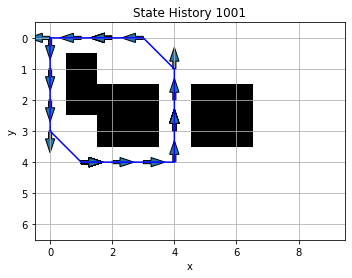

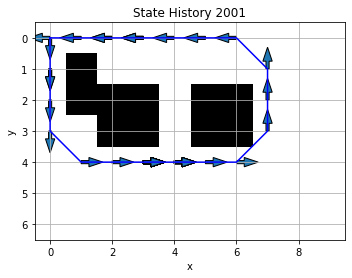

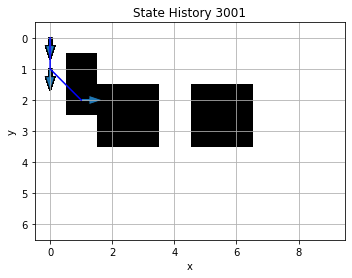

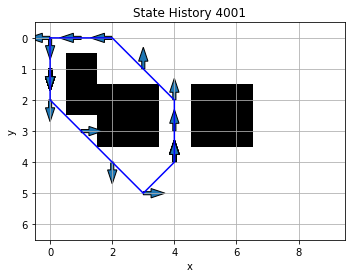

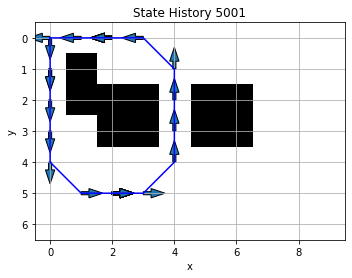

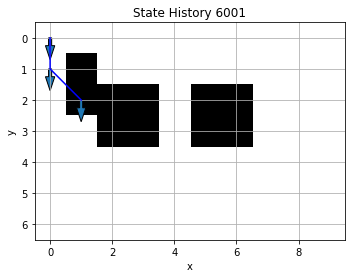

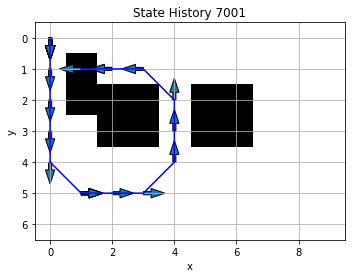

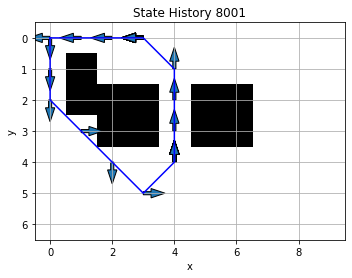

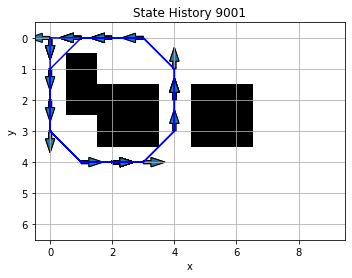

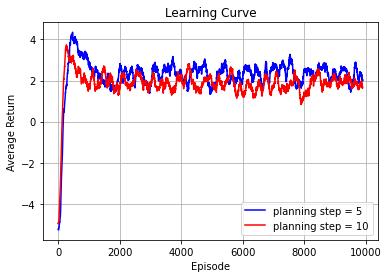

In [3]:
def test_rl_algorithm(rl_agent, car_mdp, initial_state, planning_step, n_episodes=10000, n_plot=np.inf):
    """
    Code that will be used to test your implementation of ReinforcementLearningAgent.
    As you can see, you are responsible for implementing three methods in ReinforcementLearningAgent:
        - reset (called at the start of every episode)
        - next_action (called at every time step of an episode)
        - finish_episode (called at the end of each episode)

    :param rl_agent: an instance of your ReinforcementLearningAgent class
    :param car_mdp: an instance of CarMDP
    :param init_state: the initial state
    :param n_episodes: number of episodes to use for this test
    :param n_plot: display a plot every n_plot episodes
    :return:
    """
    returns = []
    for episode in range(n_episodes):
        G = 0.  # Keep track of the returns for this episode (discount factor gamma=1)
        # Re-initialize the MDP and the RL agent
        car_mdp.reset();
        action = rl_agent.reset(initial_state)
        current_state = initial_state
        terminal = False
        while not terminal:  # Loop until a terminal state is reached
            next_state, reward, terminal, actual_action = car_mdp.step(action)    # modified
            G += reward
            action = rl_agent.next_action(current_state, action, reward, next_state, terminal, actual_action, planning_step)
            current_state = next_state
        rl_agent.finish_episode()
        returns += [G]

        # Plot the trajectory every n_plot episodes
        if episode % n_plot == 0 and episode > 0:
            car_mdp.render('State History ' + str(episode + 1))

    return returns


if __name__ == '__main__':

    # Size of the CarMDP map (any cell outside of this rectangle is a terminal state)
    width = 9
    height = 6
    initial_state = (0, 0, 2)  # Top left corner (0, 0), facing "Down" (2)
    obstacles = [(2, 2), (2, 3), (3, 2), (3, 3),  # Cells filled with obstacles are terminal states
                 (5, 2), (5, 3), (6, 2), (6, 3),
                 (1, 1), (1, 2)]
    goal_transition = ((1, 0), (0, 0))  # Transitioning from cell (1, 0) to cell (0, 0) terminates and gives a reward
    p_corr = 0.95  # Probability of actions working as intended
    
  # Create environment
    car_mdp = CarMDP(width, height, obstacles, goal_transition, initial_state, p_corr=p_corr)
  
 # Create RL agent. # You must complete this class in your solution, it is random policy right now
 # the first agent (rl_agent) is just to track the agent to see if it is learning 
        
    rl_agent = ReinforcementLearningAgent()  
    
   
    student_returns = test_rl_algorithm(rl_agent, car_mdp, initial_state, planning_step = 5, n_episodes=10000, n_plot=1000.)
    
    
    # Example plot. You need to change it according to the assignment requirements.   
    n_runs = 10
    n_episodes = 10000
    returns_5 = np.zeros((n_runs, n_episodes))
    for run in range(n_runs):    # planning step = 5
        rl_agentnew = ReinforcementLearningAgent()
        returns_5[run, :] = test_rl_algorithm(rl_agentnew, car_mdp, initial_state, planning_step = 5, n_episodes=n_episodes)
        
        
    returns_10 = np.zeros((n_runs, n_episodes))
    for run in range(n_runs):    # planning step = 10
        rl_agentnew = ReinforcementLearningAgent()
        returns_10[run, :] = test_rl_algorithm(rl_agentnew, car_mdp, initial_state, planning_step = 10, n_episodes=n_episodes)
    
        
    # Plot one curve like this for each parameter setting - the template code for ReinforcementLearningAgent just
    # returns a random action, so this example curve will just be noise. When your method is working, the mean return
    # should increase as the number of episodes increases. Feel free to change the rolling average width
    rolling_average_width = 100
    # Compute the mean (over n_runs) for each episode
    mean_return_5 = np.mean(returns_5, axis=0)
    mean_return_10 = np.mean(returns_10, axis=0)
    # Compute the rolling average (over episodes) to smooth out the curve
    rolling_average_mean_return_5 = np.convolve(mean_return_5, np.ones(rolling_average_width), 'valid')/rolling_average_width
    rolling_average_mean_return_10 = np.convolve(mean_return_10, np.ones(rolling_average_width), 'valid')/rolling_average_width
    plt.figure()
    plt.plot(rolling_average_mean_return_5, 'b-')  # Plot the smoothed average return for each episode over n_runs
    plt.plot(rolling_average_mean_return_10, 'r-')  # Plot the smoothed average return for each episode over n_runs
    plt.grid()
    plt.title('Learning Curve')
    plt.xlabel('Episode')
    plt.ylabel('Average Return')
    plt.legend(['planning step = 5', 'planning step = 10'])
    plt.show()
